## Setting up Spark

In [ ]:
!apt install libkrb5-dev
!wget https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
!pip install pyspark --user
!pip install seaborn --user
!pip install plotly --user
!pip install imageio --user
!pip install folium --user
!pip install pyspark2pmml
import pandas as pd
import os
import pickle
import requests
import json
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from collections import Counter
sc = SparkContext('local')
spark = SparkSession(sc)
from pyspark.sql import SQLContext
from pyspark.sql import DataFrameNaFunctions
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import Binarizer
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StringIndexer, VectorIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql.functions import avg
from pyspark.sql.types import *
from pyspark.sql.functions import col

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  comerr-dev krb5-multidev libgssrpc4 libkadm5clnt-mit11 libkadm5srv-mit11
  libkdb5-9
Suggested packages:
  doc-base krb5-doc krb5-user
The following NEW packages will be installed:
  comerr-dev krb5-multidev libgssrpc4 libkadm5clnt-mit11 libkadm5srv-mit11
  libkdb5-9 libkrb5-dev
0 upgraded, 7 newly installed, 0 to remove and 34 not upgraded.
Need to get 349 kB of archives.
After this operation, 1,992 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libgssrpc4 amd64 1.16-2ubuntu0.2 [54.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libkdb5-9 amd64 1.16-2ubuntu0.2 [37.3 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates

## DATASET

In [ ]:
# input_dir = 'gs://data-stroke-1/'
# df = spark.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load(input_dir+'stroke.csv')
df = spark.read.csv('/content/train.csv',inferSchema=True, header =True)
df_sk = pd.read_csv("/content/train.csv")

In [ ]:
df.printSchema()


root
 |-- diagnosis: string (nullable = true)
 |-- radius_mean: double (nullable = true)
 |-- texture_mean: double (nullable = true)
 |-- perimeter_mean: double (nullable = true)
 |-- area_mean: double (nullable = true)
 |-- smoothness_mean: double (nullable = true)
 |-- compactness_mean: double (nullable = true)
 |-- concavity_mean: double (nullable = true)
 |-- concave points_mean: double (nullable = true)
 |-- symmetry_mean: double (nullable = true)
 |-- fractal_dimension_mean: double (nullable = true)



In [ ]:
pd.DataFrame(df.take(5), columns=df.columns)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,M,17.99,20.66,117.80,991.7,0.10360,0.13040,0.120100,0.088240,0.1992,0.06069
1,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.198000,0.104300,0.1809,0.05883
2,B,9.00,14.40,56.36,246.3,0.07005,0.03116,0.003681,0.003472,0.1788,0.06833
3,B,12.21,14.09,78.78,462.0,0.08108,0.07823,0.068390,0.025340,0.1646,0.06154
4,B,12.34,14.95,78.29,469.1,0.08682,0.04571,0.021090,0.020540,0.1571,0.05708


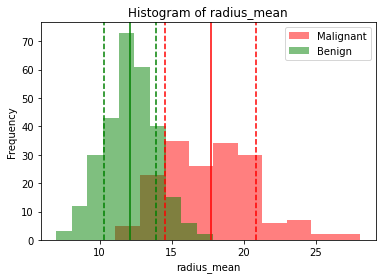

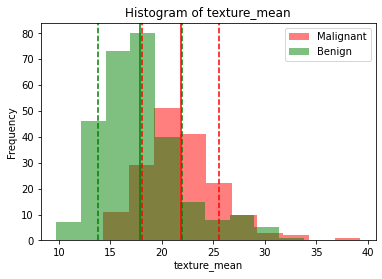

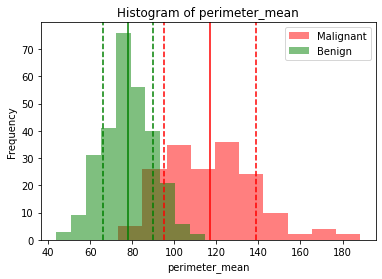

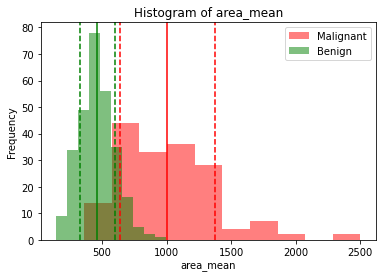

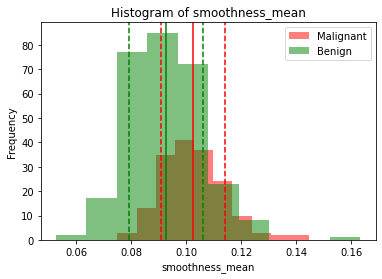

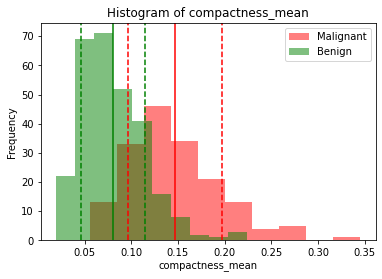

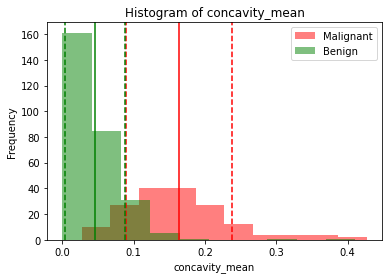

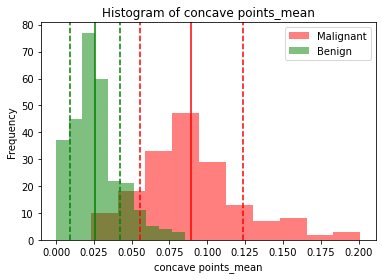

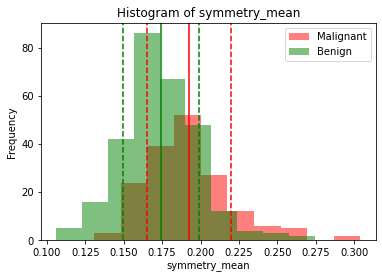

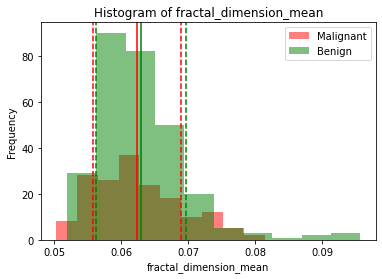

In [ ]:
for i in ('radius_mean','texture_mean','perimeter_mean','area_mean','smoothness_mean','compactness_mean','concavity_mean','concave points_mean','symmetry_mean','fractal_dimension_mean'):
  plt.figure
  df_sk[i][df_sk['diagnosis']=='M'].plot.hist(alpha=0.5,color='red',title='Histogram of '+i,label='Malignant')
  df_sk[i][df_sk['diagnosis']=='B'].plot.hist(alpha=0.5,color='green',label='Benign')
  plt.axvline(df_sk[i][df_sk['diagnosis']=='M'].mean(),color='red')
  plt.axvline(df_sk[i][df_sk['diagnosis']=='B'].mean(),color='green')
  M_diff_1=df_sk[i][df_sk['diagnosis']=='M'].mean()-df_sk[i][df_sk['diagnosis']=='M'].std()
  M_diff_2=df_sk[i][df_sk['diagnosis']=='M'].mean()+df_sk[i][df_sk['diagnosis']=='M'].std()
  B_diff_1=df_sk[i][df_sk['diagnosis']=='B'].mean()-df_sk[i][df_sk['diagnosis']=='B'].std()
  B_diff_2=df_sk[i][df_sk['diagnosis']=='B'].mean()+df_sk[i][df_sk['diagnosis']=='B'].std()
  plt.axvline(M_diff_1,color='red',linestyle = 'dashed')
  plt.axvline(M_diff_2,color='red',linestyle = 'dashed')
  plt.axvline(B_diff_1,color='green',linestyle = 'dashed')
  plt.axvline(B_diff_2,color='green',linestyle = 'dashed')
  plt.legend()
  plt.xlabel(i)
  plt.ylabel('Frequency')
  plt.show()

  
 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


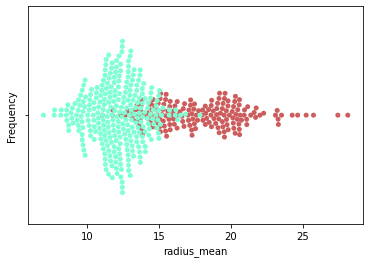

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


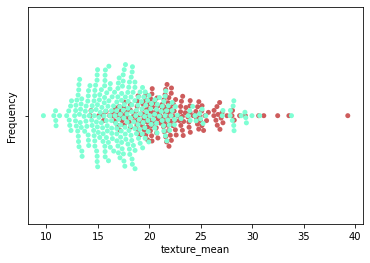

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


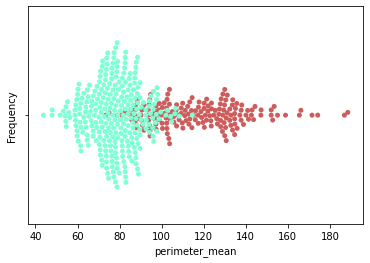

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


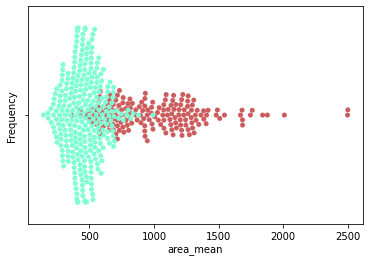

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


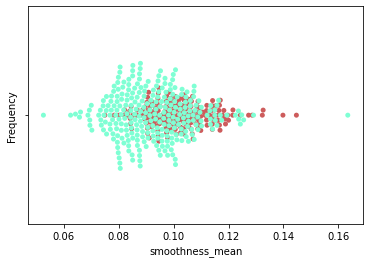

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


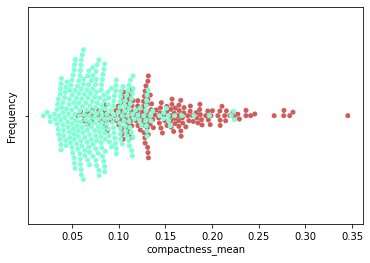

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


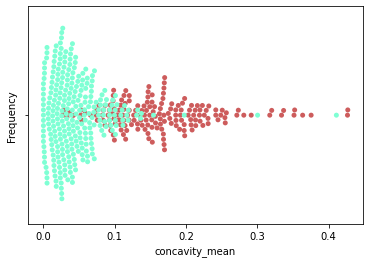

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


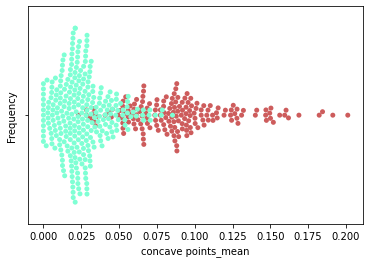

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


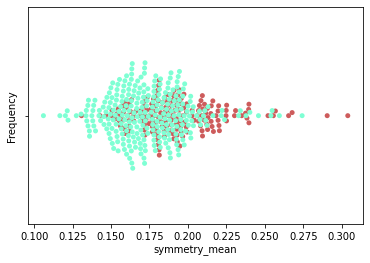

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


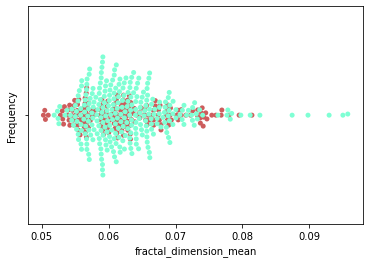

In [ ]:
import seaborn as sns
for i in ('radius_mean','texture_mean','perimeter_mean','area_mean','smoothness_mean','compactness_mean','concavity_mean','concave points_mean','symmetry_mean','fractal_dimension_mean'):
  plt.figure
  sns.swarmplot(df_sk[i][df_sk['diagnosis']=='M'],color='indianred')
  sns.swarmplot(df_sk[i][df_sk['diagnosis']=='B'],color='aquamarine')
  plt.xlabel(i)
  plt.ylabel('Frequency')
  plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


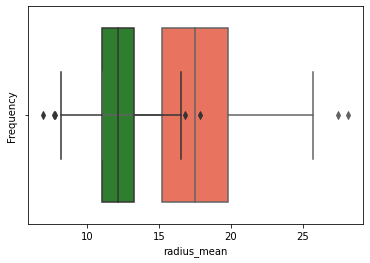

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


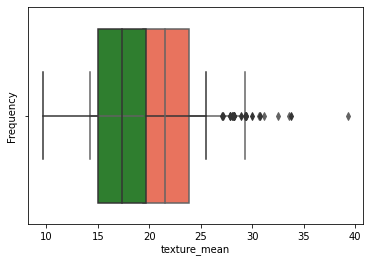

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


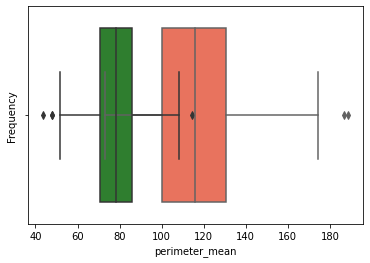

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


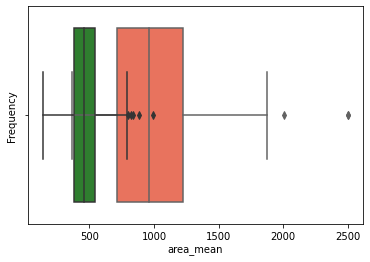

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


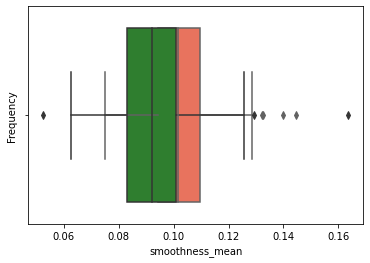

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


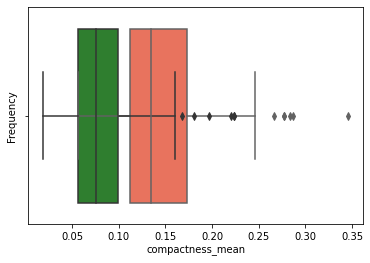

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


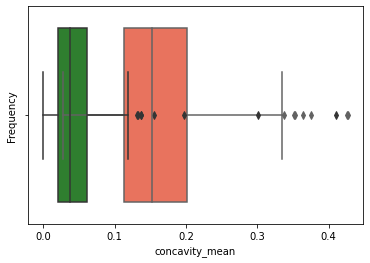

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


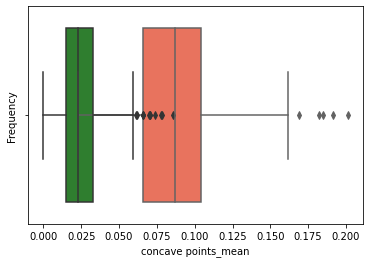

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


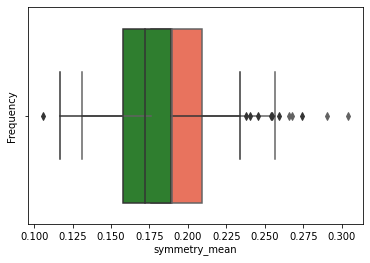

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


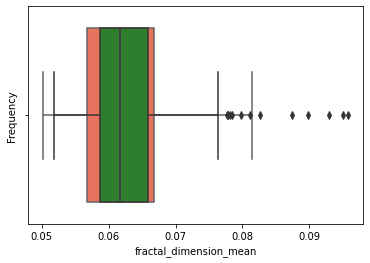

In [ ]:
import seaborn as sns
for i in ('radius_mean','texture_mean','perimeter_mean','area_mean','smoothness_mean','compactness_mean','concavity_mean','concave points_mean','symmetry_mean','fractal_dimension_mean'):
  plt.figure
  sns.boxplot(df_sk[i][df_sk['diagnosis']=='M'],color='tomato')
  sns.boxplot(df_sk[i][df_sk['diagnosis']=='B'],color='forestgreen')
  plt.xlabel(i)
  plt.ylabel('Frequency')
  plt.show()

## Number of classes

In [ ]:
df = df.withColumn('diagnosis', regexp_replace('diagnosis', 'M', '1'))
df = df.withColumn('diagnosis', regexp_replace('diagnosis', 'B', '0'))
pd.DataFrame(df.take(5), columns=df.columns)

([<matplotlib.axis.XTick at 0x7fc3246b76d0>,
 [Text(0, 0, '0'), Text(0, 0, '1')])

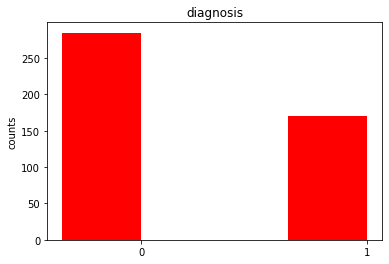

In [ ]:
from pyspark.sql.functions import *
df_sk.diagnosis.replace(to_replace = dict(M =1 , B=0), inplace = True)
responses = df.groupBy('diagnosis').count().collect()
categories = [i[0] for i in responses]
counts = [i[1] for i in responses]
 
ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='r')
 
plt.ylabel('counts')
plt.title('diagnosis')
plt.xticks(ind + width/2., categories)

## Missing Values

In [ ]:
removeAllDF = df.na.drop()

In [ ]:
removeAllDF.describe(['diagnosis']).show()

+-------+-------------------+
|summary|          diagnosis|
+-------+-------------------+
|  count|                455|
|   mean|0.37362637362637363|
| stddev|0.48429865836312913|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



In [ ]:
removeAllDF.count()

455

## Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split
feature_columns = ['radius_mean','texture_mean','perimeter_mean','area_mean','smoothness_mean','compactness_mean','concavity_mean','concave points_mean','symmetry_mean','fractal_dimension_mean']
X = df.toPandas().filter(items=feature_columns)
y = df.toPandas().filter(items=['diagnosis'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)  # splitting total as test-10 and train-90
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2222, random_state=1) # splitting train-90 as train-70 and val-20 (0.222*90/100 =20)

In [ ]:
X.shape, y.shape

((455, 10), (455, 1))

In [ ]:
print('Class labels:', np.unique(Y))

Class labels: ['0' '1']


## Balancing Minority Class (SMOTE)

In [ ]:
sm = SMOTE(random_state=12, ratio = 'auto', kind = 'regular')

In [ ]:
x_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)

print('Resampled dataset shape {}'.format(Counter(y_train_smote)))

Resampled dataset shape Counter({'0': 194, '1': 194})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Combine Resampled data back to a single Spark Dataframe

In [ ]:
# dataset = pd.DataFrame({'age':x_train_res[0], 'diabetes':x_train_res[1],'hypertension':x_train_res[2],'heart disease':x_train_res[3],'smoking history':x_train_res[4],'BMI':x_train_res[5]})
# print(dataset)
dataframe_1 = pd.DataFrame(x_train_smote,columns=feature_columns)
dataframe_2 = pd.DataFrame(y_train_smote,columns=['diagnosis'])

# frames = [dataframe_1, dataframe_2]
result = dataframe_1.combine_first(dataframe_2)

In [ ]:
type(result)

pandas.core.frame.DataFrame

In [ ]:
new_DF = spark.createDataFrame(result)

In [ ]:
type(new_DF)

pyspark.sql.dataframe.DataFrame

## Resampled Data

([<matplotlib.axis.XTick at 0x7fc309434810>,
 [Text(0, 0, '0'), Text(0, 0, '1')])

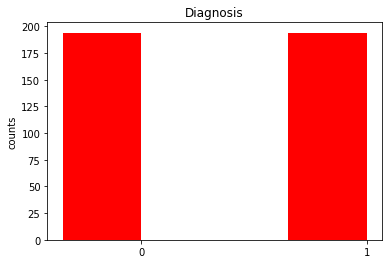

In [ ]:
responses = new_DF.groupBy('diagnosis').count().collect()
categories = [i[0] for i in responses]
counts = [i[1] for i in responses]
 
ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='r')
 
plt.ylabel('counts')
plt.title('Diagnosis')
plt.xticks(ind + width/2., categories)

## Creating Assembler

In [ ]:
new_DF = new_DF.withColumn("diagnosis", new_DF["diagnosis"].cast(DoubleType()))
binarizer = Binarizer(threshold=0.0, inputCol="diagnosis", outputCol="label")
binarizedDF = binarizer.transform(new_DF)

In [ ]:
binarizedDF.select("diagnosis", "label").show(4)

+---------+-----+
|diagnosis|label|
+---------+-----+
|      0.0|  0.0|
|      0.0|  0.0|
|      1.0|  1.0|
|      1.0|  1.0|
+---------+-----+
only showing top 4 rows



In [ ]:
binarizedDF = binarizedDF.drop('diagnosis')

In [ ]:
binarizedDF.printSchema()

root
 |-- area_mean: double (nullable = true)
 |-- compactness_mean: double (nullable = true)
 |-- concave points_mean: double (nullable = true)
 |-- concavity_mean: double (nullable = true)
 |-- fractal_dimension_mean: double (nullable = true)
 |-- perimeter_mean: double (nullable = true)
 |-- radius_mean: double (nullable = true)
 |-- smoothness_mean: double (nullable = true)
 |-- symmetry_mean: double (nullable = true)
 |-- texture_mean: double (nullable = true)
 |-- label: double (nullable = true)



In [ ]:
assembler = VectorAssembler(inputCols = feature_columns, outputCol = "features")
assembled = assembler.transform(binarizedDF)

In [ ]:
print(assembled)

DataFrame[area_mean: double, compactness_mean: double, concave points_mean: double, concavity_mean: double, fractal_dimension_mean: double, perimeter_mean: double, radius_mean: double, smoothness_mean: double, symmetry_mean: double, texture_mean: double, label: double, features: vector]


# Splitting Data

In [ ]:
(trainingData, testData) = assembled.randomSplit([0.5, 0.5], seed=13234)

In [ ]:
trainingData.count(), testData.count()

(191, 197)

## Training

In [ ]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=25, minInstancesPerNode=30, impurity="gini")
pipeline = Pipeline(stages=[dt])
model = pipeline.fit(trainingData)

## Testing

In [ ]:
predictions = model.transform(testData)

## AUC

In [ ]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
results = predictions.select(['probability', 'label'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("Test Data Aread under ROC score is : ", metrics.areaUnderROC)

Test Data Aread under ROC score is :  0.9136775922490208


## ROC

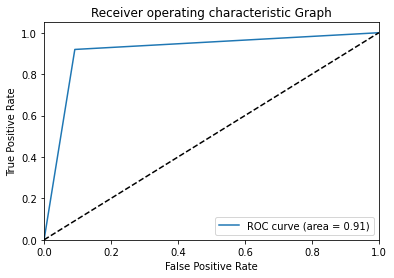

In [ ]:
from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Graph')
plt.legend(loc="lower right")
plt.show()

###DISTRIBUTION OF PREDICTIONS

In [ ]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9319000463687693


In [ ]:
# Select (prediction, true label) and compute test error
# evaluator = MulticlassClassificationEvaluator(
#     labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))
accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g " % (1.0 - accuracy))

treeModel = model.stages[0]
# summary only
print(treeModel)

Test Area Under ROC: 0.9136775922490208
0.9136775922490208
Test Error = 0.0863224 
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_fe0c1819e87a, depth=1, numNodes=3, numClasses=2, numFeatures=10


In [ ]:
from pyspark.ml.feature import RFormula

formula = RFormula(formula = "label ~ .")
classifier = DecisionTreeClassifier(maxDepth=25, minInstancesPerNode=30, impurity="gini")
pipeline = Pipeline(stages = [formula, classifier])
pipelineModel = pipeline.fit(trainingData)

In [ ]:
!pip install pyspark2pmml

  Created wheel for pyspark2pmml: filename=pyspark2pmml-0.5.1-cp37-none-any.whl size=2418 sha256=600ed41e51c805a570e3bd099030f0c167f1786c537687e6ff97c38cd284be32
  Stored in directory: /root/.cache/pip/wheels/fa/f2/e9/e2370733daa2c5fc3271a64eba149a57d44a607901760d17b3
Successfully built pyspark2pmml


In [ ]:
from pyspark2pmml import PMMLBuilder
pmmlBuilder = PMMLBuilder(sc, trainingData, model).putOption(classifier, "compact", True)
pmmlBuilder.buildFile("tumor-diagnosis.pmml")